<a href="https://colab.research.google.com/github/AshrithSagar/CP260-RP-2025/blob/develop/3_Lab_CP260_2025_Q.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
**Lab 3: Non-Linear Least Squares based Pose Optimization**

Reference:

Chapter 10 of "Probabilistic robotcs", Thrun

Chapter 2,3 of "Factor Graphs" by Daellert


"Scipy's: Least squares function":
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

**Q1**

Use scipys least squares solver to estimate the location of the robot, given the bearing measurements.

L is the set of landmarks.

Use the appropriate loss function to handle outliers.

In [ ]:
L = np.array([
    [2,6],
    [8,6],
    [9,2],
    [11,6],
    [15,1],
    [20.1,21.1],
    [-2,3.4],
    [3,4],
    [8,9],
    [10,10],
    [13,45],
    [8.0,9.1]
])

def Meas_Bearing(p, L, std=0.0,n_outliers=0):
  '''measure bearing from p to each point of L
  inputs:
  p: x,y location
  L: array of 2D landmarks
  std: std deviation of each bearing measurment
  n_outliers: number of outliers
  returns
  a: array of bearing measurements to each landmark
  '''
  error = np.random.normal(0,std,L.shape[0])
  outliers = rng.integers(0, L.shape[0], n_outliers)
  error[outliers] *= 100
  return np.arctan2(L[:,1]-p[1],L[:,0]-p[0])+error



p0 = np.array([100.0,100.0])


p_true=np.array([0.0,0.0]) #At origin
m = Meas_Bearing(p_true,L,0.1,2)

#<Your code here>



#ans=
print(ans)

85590.91537851226 116985.73150157282
-0.5913175510351197 1.6085347521618956


**Q2**

Setup a pose graph optimization for poses with measurement factors for pose and landmarks at every 100 time steps

Use the particle filter based pose estimation as starting values and then optimize this pose graph using the scipy's least square solver.

Plot the measurement error and compare with just particle filter based estimator.


Note the code below just does the particle filter based estimator - just for your reference.

In [ ]:
def create_uniform_particles(x_range, y_range, hdg_range, N):
  '''Uniform distributin of particles
  x_range: (min, max)
  y_range: (min, max)
  hdg_range: (min, max)
  N: number of particles
  '''
  particles = np.empty((N, 3))
  particles[:, 0] = np.random.uniform(x_range[0], x_range[1], size=N)
  particles[:, 1] = np.random.uniform(y_range[0], y_range[1], size=N)
  particles[:, 2] = np.random.uniform(hdg_range[0], hdg_range[1], size=N)
  particles[:, 2] %= 2 * np.pi
  weights = np.ones(N)/N
  return particles,weights

def plot_particles(particles):
  plt.scatter(particles[:,0],particles[:,1],s=0.1,color='r')
  plt.show()

def predict_particles(particles, u, std, dt=0.1):
  """ move according control input
  particle: numpy array of particles with (x,y,ang)
  u : control input(linear speed, angular speed)
  std: std. deviation of process noise (dist std, ang std)
  dt: time step
  returns
  updated list of particles
  """

  N = len(particles)
  # update heading
  particles[:, 2] += u[1]*dt + (np.random.randn(N) * std[1])
  particles[:, 2] %= 2 * np.pi

  # move each in the (noisy) commanded direction
  dist = (u[0] * dt) + (np.random.randn(N) * std[0])
  particles[:, 0] += np.cos(particles[:, 2]) * dist
  particles[:, 1] += np.sin(particles[:, 2]) * dist
  return particles


In [ ]:
def update_true_pose(pose,u, dt=0.1,pstd=np.array([0.0,0.0])):
  '''update the true pose
  pose: (x,y,ang)
  u: (linear velocity, angular velocity)
  std: (linear noise, angular noise)
  dt: time step
  cov: noise std dev (linear velocity, ang. velocity)
  return
  updated pose
  '''
  # update heading
  pose[2] += (u[1]+np.random.normal(0,pstd[1]))*dt
  pose[2] %= 2 * np.pi

  # move in the commanded direction
  dist = (u[0]+np.random.normal(0,pstd[0])) * dt
  pose[0] += np.cos(pose[2]) * dist
  pose[1] += np.sin(pose[2]) * dist
  return pose

def make_measurements(pose, mapL, dist_range=10.0, R=np.array([0.0,0.0])):
  ''' make measurements of the land from the given pose
  pose: current pose
  mapL: list of landmarks (x,y) with their ids
  dist_range: only landmarks withing dist_range of pose will be measured
  ang_range: only landmarks in the relative angle range of pose will be measured (120)
  R: Measurement std deviation (distance, angle), with zero mean gaussian

  return
  Z: (x, y, ang, landmark id) of measurements
  '''
  Z=[]
  dstd=R[0]
  astd=R[1]
  for lid in mapL: #iterate through all landmarks
    lx,ly = mapL[lid]
    if (np.linalg.norm(pose[0:2]-np.array([lx,ly])) < dist_range):
      #landmark within measurement range
      ang = np.arctan2(ly-pose[1],lx-pose[0])-pose[2] + (np.random.randn() * astd)
      if (ang > np.pi):
        ang -= 2*np.pi
      elif (ang < -np.pi):
        ang += 2*np.pi
      dist = np.linalg.norm(pose[0:2]-np.array([lx,ly])) + (np.random.randn() * dstd)
      Z.append([dist,ang,lid])
  return np.array(Z)


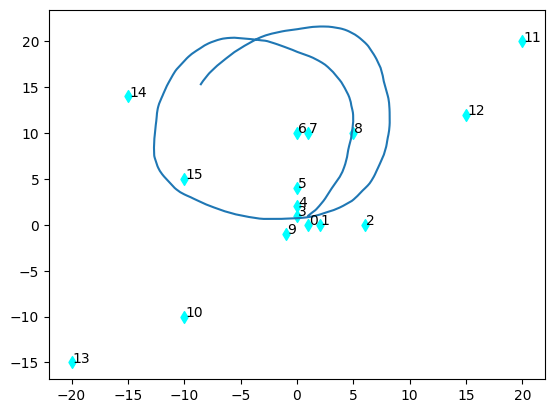

In [ ]:
#list of landmarks
mapL={
    0:[1,0],
    1:[2,0],
    2:[6,0],
    3:[0,1],
    4:[0,2],
    5:[0,4],
    6:[0,10],
    7:[1,10],
    8:[5,10],
    9:[-1,-1],
    10:[-10,-10],
    11:[20,20],
    12:[15,12],
    13:[-20,-15],
    14:[-15,14],
    15:[-10,5]
}

dt=0.1 #s of time step
NT=10000 # time steps of each of size dt

pose = np.zeros((NT,3))
pose[0]=(1,1,np.pi/4) #initially pointing along diagonal

u = (0.1,0.01) #go in a straight line withe speed of 1m/s

pstd = np.array([0.01,0.1]) #std deviation for post update (linear, angular)

for i in np.arange(1,NT):
  pose[i] = update_true_pose(pose[i-1],u,dt,pstd)
  Z = make_measurements(pose[i],mapL)
  #if i % 100 == 0:
  #  print(Z)

fig,ax = plt.subplots()
lmrk = np.array(list(mapL.values()))
ax.scatter(lmrk[:,0],lmrk[:,1],marker="d",c="cyan")
for lid in mapL:
  ax.annotate(str(lid), (mapL[lid][0]+0.1,mapL[lid][1]))
ax.plot(pose[:,0],pose[:,1])
plt.show()

In [ ]:
def simple_resample(particles, weights):
  N = len(particles)
  cumulative_sum = np.cumsum(weights)
  cumulative_sum[-1] = 1. # avoid round-off error
  indexes = np.searchsorted(cumulative_sum, np.random.random(N))
  return indexes

def Neff(weights):
  '''
  return effective number of particles, calculated
  as a function of inverse sum of weights square
  '''
  return 1.0/np.sum(np.square(weights))

def resample_from_index(particles, weights, indexes):
  particles[:] = particles[indexes]
  weights.resize(len(particles))
  weights.fill(1.0 / len(weights))
  return particles, weights

def moments(particles, weights):
  '''
  return the mean and covariance of the weighted particles
  '''
  mean = np.average(particles, weights=weights, axis=0)
  cov = np.average((particles - mean)**2, weights=weights, axis=0) #not quite correct
  return mean, cov


In [ ]:
def low_variance_resample(particles, weights):
  N = len(weights)
  #<your code here>

  # make N subdivisions, choose positions
  # with a consistent random offset
  positions = (np.arange(N) + np.random.random()) / N

  indexes = np.zeros(N, 'i')
  cumulative_sum = np.cumsum(weights)
  i, j = 0, 0
  while i < N:
    if positions[i] < cumulative_sum[j]:
      indexes[i] = j
      i += 1
    else:
      j += 1
  return indexes

def adaptive_low_variance_resample(particles, weights, wslow, wfast):
  #<your code here>

  return indexes

def update_particle_weights(particles, weights, Z, R, mapL):
  ''' update the weights with measurement likelihood
  particles: Nx3 array of particles with x,y, ang
  weights: Nx1 array of weight for each particle
  Z: M x 3 (range, ang, landmark id) is the set of measurements
  R: measurement noise covariance R[0]: distance cov, R[1]: ang covariance
  mapL: L x 2 (lx, ly) location of landmarks in the map
  returns
  updated weights (multiplied by likelihood)
  '''


  #for each measurement
  for zdist,zang,zid in Z:
    #<your code>

    lx,ly = mapL[zid]
    distances = np.linalg.norm(particles[:, 0:2] - np.array([lx,ly]), axis=1)
    angles = np.arctan2(ly - particles[:, 1], lx - particles[:, 0])
    angles -= particles[:, 2]
    angles = np.where(angles> np.pi, angles-2*np.pi, angles)
    angles = np.where(angles<-np.pi, angles+2*np.pi, angles)
    lkl_dist=scipy.stats.norm(distances, R[0]).pdf(zdist)
    weights *= lkl_dist
    lkl_ang=scipy.stats.norm(angles, R[1]).pdf(zang)
    weights *= lkl_ang
  #end for
  weights += 1.e-16  # avoid round-off to zero
  weights /= sum(weights)

  return weights


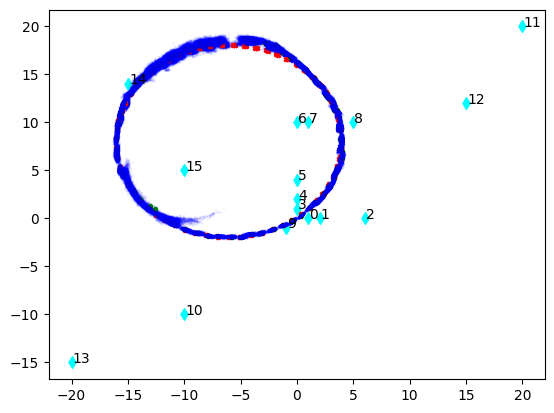

In [ ]:
NP=3000 #number of particles
NT=10000 #number of time steps for simulation
dt=0.1 #time step

u = (0.1,0.01) #go in a curve with speed of 1m/s
pstd = np.array([0.1,0.1]) #lin, ang std for actual motion

P = np.array([0.1,0.1]) #linear, angular std deviation for process model

dstd = 0.5
astd = 0.5
R = np.array([dstd,astd]) #distance, angle std deviation for measurement


fig,ax = plt.subplots()
lmrk = np.array(list(mapL.values()))
ax.scatter(lmrk[:,0],lmrk[:,1],marker="d",c="cyan")
for lid in mapL:
  ax.annotate(str(lid), (mapL[lid][0]+0.1,mapL[lid][1]))


pose = np.zeros((NT+1,3))
pose[0]=(1,1,np.pi/4) #initially pointing along diagonal
particles,weights = create_uniform_particles((0,10),(0,10),(0,2*np.pi),NP)

#average of slow/fast weights for adaptive resampling
wslow = np.average(weights)
wfast = np.average(weights)
a_slow=1/100.0
a_fast=1/10.0


mean = np.zeros((NT+1,3))
mean[0],_ = moments(particles,weights)

for i in np.arange(0,NT):
  #<your code>
  pose[i+1] = update_true_pose(pose[i],u,dt)
  Z = make_measurements(pose[i+1],mapL,dist_range=10.0, R=R)
  particles = predict_particles(particles,u,std=P,dt=dt)
  weights = update_particle_weights(particles, weights, Z, R=R, mapL=mapL)
  mean[i+1],_ = moments(particles,weights)

  #updated weights
  wslow = wslow + a_slow*(wslow-np.average(weights))
  wfast = wfast + a_fast*np.average(weights)

  if ((i+1) % 100 == 0): #plot
    ax.scatter(pose[i+1,0],pose[i+1,1],s=10.0,marker="X", c="r")
    ax.scatter(mean[i+1,0],mean[i+1,1],s=10.0,marker="P", c="g")
    ax.scatter(particles[:,0],particles[:,1],s=0.1,c='b',alpha=0.1)

  #<Your code for resampling>
  if (Neff(weights) < NP/3): #increase diversity of particles by resampling

    #indexes = simple_resample(particles,weights)
    indexes = low_variance_resample(particles,weights)
    #indexes = adaptive_low_variance_resample(particles,weights,wslow, wfast)
    particles,weights = resample_from_index(particles,weights,indexes)

ax.scatter(pose[-1,0],pose[-1,1],s=10.0,marker="X", c="r")
ax.scatter(mean[-1,0],mean[-1,1],s=10.0,marker="P", c="g")
ax.scatter(particles[:,0],particles[:,1],s=0.1,c='b',alpha=0.1)
plt.show()

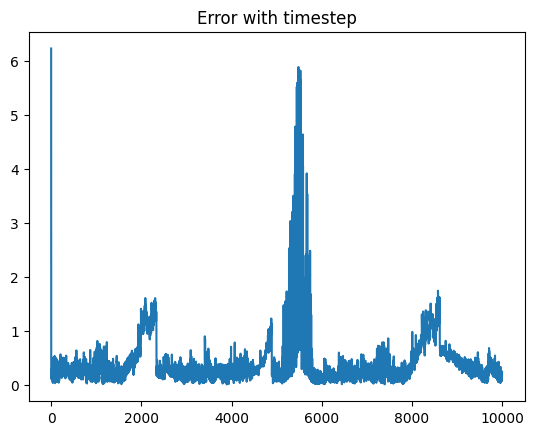

In [ ]:
plt.title("Error with timestep")
plt.plot(np.linalg.norm(mean-pose, axis=1))
plt.show()

In [ ]:
print(pose[-1])
print(mean[-1])

[-15.85558695  10.14896306   4.50221286]
[-15.88206511   9.94343491   4.63294783]
